# Loading Libraries

* source: https://goodboychan.github.io/python/tensorflow/mit/2021/02/14/music-generation.html

In [111]:
import tensorflow as tf
import numpy as np
import os
import re
import time
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Defining Functions

### Get filenames in directory

In [112]:
def abc_filenames(datapath='abcnotation_midi-test', count=False):
    songs = [os.path.join(datapath, f) for f in os.listdir(datapath) if os.path.isfile(os.path.join(datapath, f))]
    if count==True:
        print('Found {} songs in directory'.format(len(songs)))
    return songs

### ABC file example

In [113]:
def abc_example():
    songs = abc_filenames(count=True)
    with open(songs[1], 'r') as f:
        example_song = f.read()
    print('\nExample Song: ')
    print(example_song[1:-2])

### Join all ABC files in a single list

In [114]:
def join_songs(filenames):
    songs = []
    for filename in filenames:
        f = open(filename,'r', encoding='utf8')
        text = f.read()
        songs.append(text[1:-2])
    songs_joined = '\n\n'.join(songs)
    return songs_joined

### Map char2idx and idx2char

In [115]:
def abc_mapIndex(songs,show=False):
    vocab = sorted(set(songs))
    char2idx = {u:i for i,u in enumerate(vocab)}
    idx2char = np.array(vocab)
    if show==True:
        print("\nThere are", len(vocab), "unique characters in the dataset")
        print('\n{')
        for char,_ in zip(char2idx, range(20)):
            print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
        print('  ...\n}')
    return [char2idx,idx2char]

### Vectorize songs (string --> index)

In [116]:
def vectorize_string(string,char2idx,show=False):
    vectorized_list = np.array([char2idx[s] for s in string]) 
    if show==True:
        print ('{} ---- characters mapped to int ----> {}'.format(repr(string[:10]), vectorized_list[:10]))
        assert isinstance(vectorized_list, np.ndarray), "returned result should be a numpy array"
    return vectorized_list

### Batch functions 

In [117]:
def test_batch_func_types(func, args):
    ret = func(*args)
    assert len(ret) == 2, "[FAIL] get_batch must return two arguments (input and label)"
    assert type(ret[0]) == np.ndarray, "[FAIL] test_batch_func_types: x is not np.array"
    assert type(ret[1]) == np.ndarray, "[FAIL] test_batch_func_types: y is not np.array"
    print("[PASS] test_batch_func_types")
    return True


def test_batch_func_shapes(func, args):
    dataset, seq_length, batch_size = args
    x, y = func(*args)
    correct = (batch_size, seq_length)
    assert x.shape == correct, "[FAIL] test_batch_func_shapes: x {} is not correct shape {}".format(x.shape, correct)
    assert y.shape == correct, "[FAIL] test_batch_func_shapes: y {} is not correct shape {}".format(y.shape, correct)
    print("[PASS] test_batch_func_shapes")
    return True


def test_batch_func_next_step(func, args):
    x, y = func(*args)
    assert (x[:,1:] == y[:,:-1]).all(), "[FAIL] test_batch_func_next_step: x_{t} must equal y_{t-1} for all t"
    print("[PASS] test_batch_func_next_step")
    return True


def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  # list of input sequences for the training batch
  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  # list of output sequences for the training batch
  output_batch = [vectorized_songs[i+1: i+1+seq_length] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

### Testing with Batches

In [118]:
def letsTest(vectorized_songs, seq_length, batch_size, idx2char):
    # Perform some simple tests to make sure your batch function is working properly!
    print('\nPerforming some simple tests to make sure the batch function is working properly') 
    test_args = (vectorized_songs, seq_length, batch_size)
    if not test_batch_func_types(get_batch, test_args) or \
       not test_batch_func_shapes(get_batch, test_args) or \
       not test_batch_func_next_step(get_batch, test_args): 
        print("======\n[FAIL] could not pass tests")
    else: 
        print("======\n[PASS] passed all tests!")

    # Example of how it works
    print('\nExample of how it works:\n')
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)

    for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
        print("Step {:3d}".format(i))
        print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
        print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

### Building RNN Model

In [119]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )


def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #          of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #          into the vocabulary size. 
    tf.keras.layers.Dense(units=vocab_size)
  ])

  return model


# define the loss function to compute and return the loss between the true labels and predictions (logits). Set the argument from_logits=True.
#from numba import jit, cuda
#@jit()
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss  


# print-out the model's progress through training
class PeriodicPlotter:
    def __init__(self, sec, xlabel='', ylabel='', scale=None):
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.sec = sec
        self.scale = scale
        self.tic = time.time()

    def plot(self, data):
        if time.time() - self.tic > self.sec:
            plt.cla()

        if self.scale is None:
            plt.plot(data)
        elif self.scale == 'semilogx':
            plt.semilogx(data)
        elif self.scale == 'semilogy':
            plt.semilogy(data)
        elif self.scale == 'loglog':
            plt.loglog(data)
        else:
            raise ValueError("unrecognized parameter scale {}".format(self.scale))

        plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        self.tic = time.time()


### Training Model

In [120]:
def train_step(x, y, model, optimizer): 
    # Use tf.GradientTape()
    with tf.GradientTape() as tape:
        # feed the current input into the model and generate predictions
        y_hat = model(x)
        # compute the loss!
        loss = compute_loss(y, y_hat)

    # function call for gradient computation. 
    grads = tape.gradient(loss, model.trainable_variables)
  
    # Apply the gradients to the optimizer so it can update the model accordingly
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

### Generating Text (Songs)

In [121]:
def generate_text(model, start_string, generation_length, char2idx, idx2char):
    # Evaluation step (generating ABC text using the learned RNN model)

    # convert the start string to numbers (vectorize)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        predictions = model(input_eval)
        # Remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
        # multinomial distribution to sample
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        # Pass the prediction along with the previous hidden state
        #   as the next inputs to the model
        input_eval = tf.expand_dims([predicted_id], 0)
        # add the predicted character to the generated text!
        # Hint: consider what format the prediction is in vs. the output
        text_generated.append(idx2char[predicted_id])
    
    return (start_string + ''.join(text_generated))

# Getting Prepared

### Getting Songs and Example

In [122]:
datapath = "abcnotation_midi-test"
filenames = abc_filenames(datapath)
abc_example()

Found 1126 songs in directory

Example Song: 
X:1
T:001 - AntÃƒÂ­fona
T:Letra: Henry Maxwell Wright (1849-1931)
T:MÃƒÂºsica: William Henry Monk (1823-1889)
L:1/4
M:4/4
K:Bmaj
W:
W:
W:1. A Ti, ÃƒÂ³ Deus, fiel e bom Senhor.
W:Eterno Pai, Supremo Benfeitor,
W:NÃƒÂ³s, os teus servos, vimos dar louvor,
W:Aleluia! Aleluia!
W:
W:2. A Ti, Deus Filho, Salvador Jesus,
W:Da graÃƒÂ§a a fonte, da verdade a luz,
W:Por teu amor, medido pela cruz,
W:Aleluia! Aleluia!
W:
W:
W:
W:3. A Ti, ÃƒÂ³ Deus, real Consolador,
W:Divino fogo, santificador,
W:Que nos anima e nos acende o amor,
W:Aleluia! Aleluia!
W:
W:4. A Ti, Deus trino, Poderoso Deus,
W:Que estÃƒÂ¡s presente sempre junto aos teus,
W:A ministrar as bÃƒÂªnÃƒÂ§ÃƒÂ£os lÃƒÂ¡ dos cÃƒÂ©us,
W:Aleluia! Aleluia!
W:
W:
V:1 clef=treble
"B"D2 "F#"D C | "G#m"B,2 "D#m"F2 | "E"G F F "F#"E | "B"D4 | D2 E F | "E"G2 "B"F2 | "C#m7"E C D "C#7"^E | "F#"F4 | "B"D2 "F#"D C | "G#m"B,2 "D#m"F2 | "E"F =E "G#7"E D | "C#m"C4 | %12
w:1.~A Ti, ÃƒÂ³ Deus, fi-el e bom Se-nhor. E-

### Joining all ABC songs in a single list and mapping index

In [123]:
songs = join_songs(filenames)
char2idx, idx2char = abc_mapIndex(songs,show=True)


There are 130 unique characters in the dataset

{
  '\t':   0,
  '\n':   1,
  ' ' :   2,
  '!' :   3,
  '"' :   4,
  '#' :   5,
  '$' :   6,
  '%' :   7,
  '&' :   8,
  "'" :   9,
  '(' :  10,
  ')' :  11,
  '*' :  12,
  '+' :  13,
  ',' :  14,
  '-' :  15,
  '.' :  16,
  '/' :  17,
  '0' :  18,
  '1' :  19,
  ...
}


### Vectorize songs and check the before (string) and after (index)

In [124]:
vectorized_songs = vectorize_string(string=songs, char2idx=char2idx, show=True)
print(vectorized_songs)

'X:0\nT:00. ' ---- characters mapped to int ----> [58 28 18  1 54 28 18 18 16  2]
[58 28 18 ... 71 79 16]


In [125]:
letsTest(vectorized_songs=vectorized_songs, seq_length=5, batch_size=1, idx2char=idx2char)


Performing some simple tests to make sure the batch function is working properly
[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!

Example of how it works:

Step   0
  input: 28 (':')
  expected output: 51 ('Q')
Step   1
  input: 51 ('Q')
  expected output: 87 ('u')
Step   2
  input: 87 ('u')
  expected output: 71 ('e')
Step   3
  input: 71 ('e')
  expected output: 2 (' ')
Step   4
  input: 2 (' ')
  expected output: 73 ('g')


### Initial Model (default hyperparameters)

In [126]:
vocab = sorted(set(songs))
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (32, None, 256)           33280     
_________________________________________________________________
lstm_8 (LSTM)                (32, None, 1024)          5246976   
_________________________________________________________________
dense_8 (Dense)              (32, None, 130)           133250    
Total params: 5,413,506
Trainable params: 5,413,506
Non-trainable params: 0
_________________________________________________________________
None


In [127]:
# testing initial model
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 130) # (batch_size, sequence_length, vocab_size)


In [128]:
# prediction for initial model (untrained)
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
print(sampled_indices)
print("\nInput: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

[ 18  86  72  18  33  76 110  59  45 107  16  54  43   1 106  73 112  93
  61  38 117  42 121  80 112  41  37   1  26  94  79  67  42  32   2  12
   7 122 115  10   8  61  80  29   3   2  12  49  88  76  74  43  29  93
  80 129  60  52  34   3  20 105 120  51  10 128  72  54  98  75  73  59
  19  60  38  45  87  26  26  93   9   9 108   8  47 104 125  38  41  51
 116  74  53  93  67   6  86 113  38  41]

Input: 
 ':|\n|:A,,C,C,|C,2G,,|C,>B,,A,,|G,,3|C,C,C,|A,,2C,|D,A,,2|D,2z:|\nW:\nW:\nW:  From Musica Viva - http://w'

Next Char Predictions: 
 "0tf0?jÃYK¶.TI\nµgà{[DèHûnàGC\n8|maH> *%–ä(&[n;! *OvjhI;{n™ZR@!2´öQ(€fT¡igY1ZDKu88{''º&M³”DGQçhS{a$táDG"


In [129]:
example_batch_loss = compute_loss(y, pred)
print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 130)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.8678937


C:\Users\nmhahn\AppData\Local\Temp\ipykernel_13504\308551449.py:30: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "compute_loss" failed type inference due to: Unknown attribute 'sparse_categorical_crossentropy' of type Module(<module 'keras.api._v2.keras.losses' from 'C:\\Users\\nmhahn\\anaconda3\\envs\\tf-gpu\\lib\\site-packages\\keras\\api\\_v2\\keras\\losses\\__init__.py'>)

File "C:\Users\nmhahn\AppData\Local\Temp\ipykernel_13504\308551449.py", line 32:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  ^

During: typing of get attribute at C:\Users\nmhahn\AppData\Local\Temp\ipykernel_13504\308551449.py (32)

File "C:\Users\nmhahn\AppData\Local\Temp\ipykernel_13504\308551449.py", line 32:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  ^

  @jit()
C:\Users\nmhahn\anaconda3\env

### Define Parameters

In [130]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

In [131]:
# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

### Checkpoint (save weights)

In [132]:
checkpoint_dir = './training_checkpoints' # location
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

### Initiate model with parameters specified

In [133]:
# instantiate a new model for training using the `build_model` function and the hyperparameters create
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

# instantiate an optimizer with its learning rate.
# Checkout the tensorflow website for a list of supported optimizers. https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
# Try using the Adam optimizer to start
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Begin Training

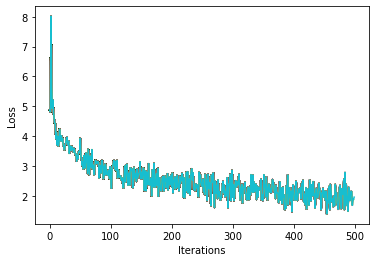

100%|██████████| 500/500 [02:33<00:00,  3.26it/s]


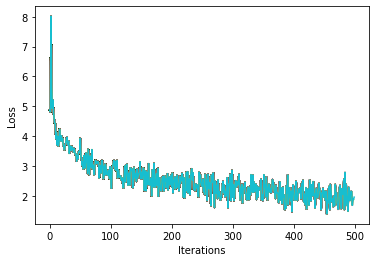

In [134]:
history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(500)):

    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
    loss = train_step(x_batch, y_batch, model, optimizer)

    # Update the progress bar
    history.append(loss.numpy().mean())
    plotter.plot(history)

    # Update the model with the changed weights!
    if iter % 100 == 0:     
        model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)